In [1]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Concatenate, Activation, Dense, BatchNormalization, LeakyReLU, Reshape, 
                                     Conv2DTranspose, Conv2D, Dropout, Flatten, Dense, ZeroPadding2D)
from tensorflow import keras
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.utils import img_to_array
from keras.utils import load_img
import datetime
import glob
import os
import time
from tqdm import tqdm
import numpy as np
from numpy.random import randn
from numpy.random import randint
from IPython import display
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0],True)

Num GPUs Available:  1


In [4]:
def load_images(img_path, size=(256, 256)):
    img_list = list()
    for filename in tqdm(glob.glob(img_path + '/*')):
        pixels = load_img(filename, target_size=size)
        pixels = img_to_array(pixels)
        pixels = (pixels-127.5)/127.5
        img_list.append(pixels)
    return np.asarray(img_list)

In [5]:
images = load_images('Data/Face')

100%|██████████| 1440/1440 [01:44<00:00, 13.75it/s]


In [6]:
sketches = load_images('Data/Sketch')

100%|██████████| 1440/1440 [01:11<00:00, 20.19it/s]


In [7]:
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [8]:
train_ds = [sketches[0:1400], images[0:1400]]
test_ds = [sketches[1400:], images[1400:]]

In [9]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())
    result.add(tf.keras.layers.LeakyReLU())
    return result

In [10]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tf.keras.layers.BatchNormalization())
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    result.add(tf.keras.layers.ReLU())
    return result

In [11]:
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    down_stack = [
      downsample(64, 4, apply_batchnorm=False),
      downsample(128, 4),
      downsample(256, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
      downsample(512, 4),
    ]
    up_stack = [
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4, apply_dropout=True),
      upsample(512, 4), 
      upsample(256, 4),
      upsample(128, 4),
      upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh')
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

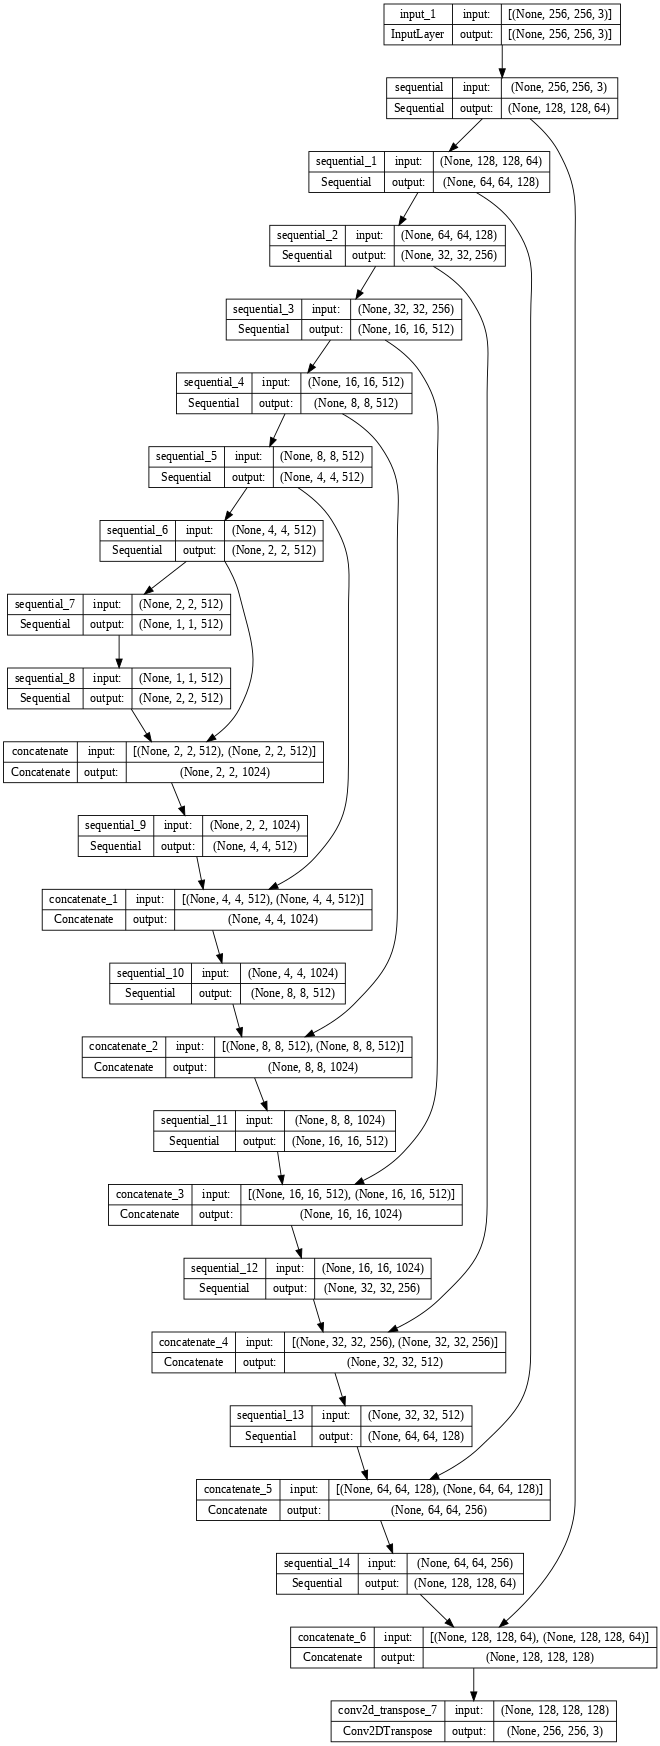

In [12]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [13]:
LAMBDA = 100

In [14]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [15]:
def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss, gan_loss, l1_loss

In [16]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return tf.keras.Model(inputs=[inp, tar], outputs=last)

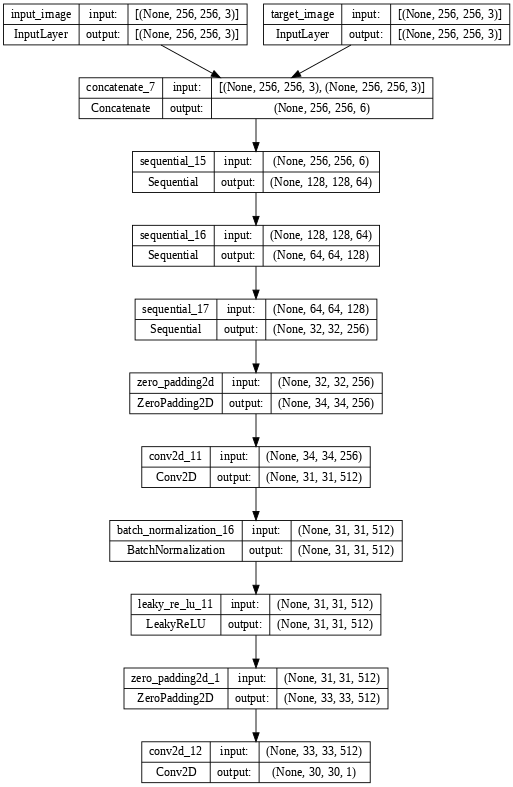

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [18]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

In [19]:
generator.summary(), discriminator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 64  3072        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  131584      ['sequential[0][0]']             
                                                                                              

(None, None)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [22]:
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

In [23]:
def fit(train_ds, epochs):
    start = time.time()
    step = 0
    for i in range (0,epochs*1400):
        input_image = train_ds[0][i%1400].reshape([1, 256, 256, 3])
        target = train_ds[1][i%1400].reshape([1, 256, 256, 3])
        print(step)
        if (step) % 100 == 0:
            display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 100 steps: {time.time()-start:.2f} sec\n')
            start = time.time()
            print(f"Step: {step}")
        train_step(input_image, target, step)
        generator.save('generator_model.h5')
        discriminator.save('discriminator_model.h5')
        step += 1

In [24]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15, 15))
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [ ]:
fit(train_ds, 5)

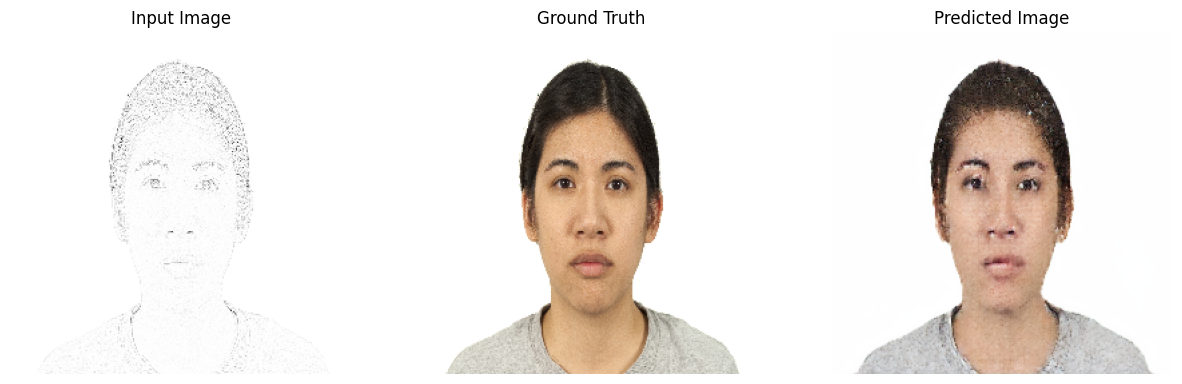

In [27]:
generate_images(generator, test_ds[0][1].reshape([1,256,256,3]), test_ds[1][1].reshape([1,256,256,3]))

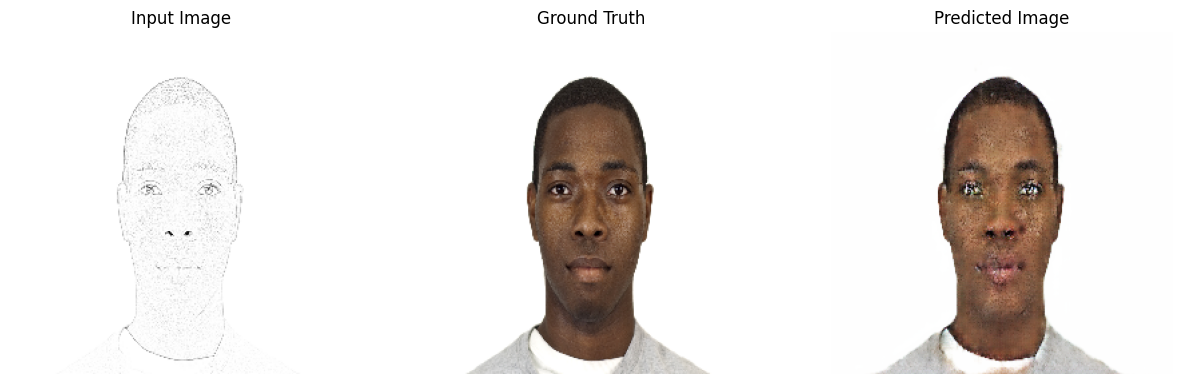

In [28]:
generate_images(generator, test_ds[0][5].reshape([1,256,256,3]), test_ds[1][5].reshape([1,256,256,3]))

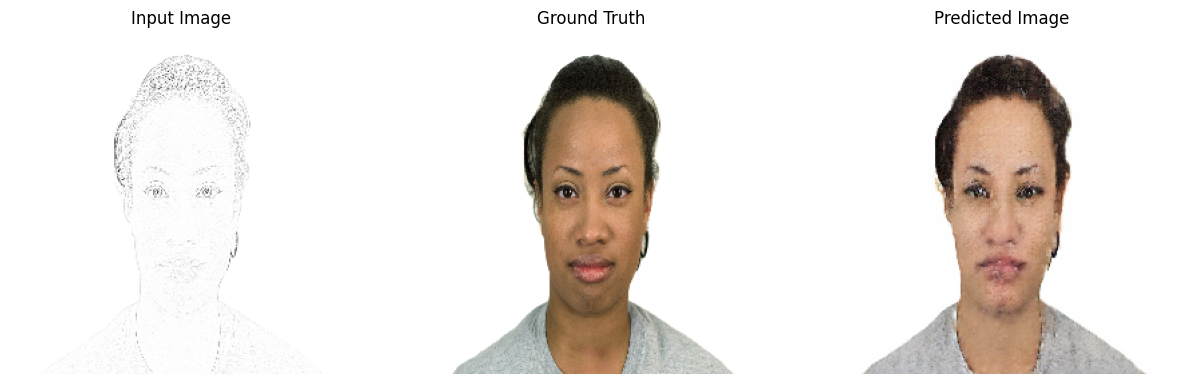

In [29]:
generate_images(generator, test_ds[0][10].reshape([1,256,256,3]), test_ds[1][10].reshape([1,256,256,3]))

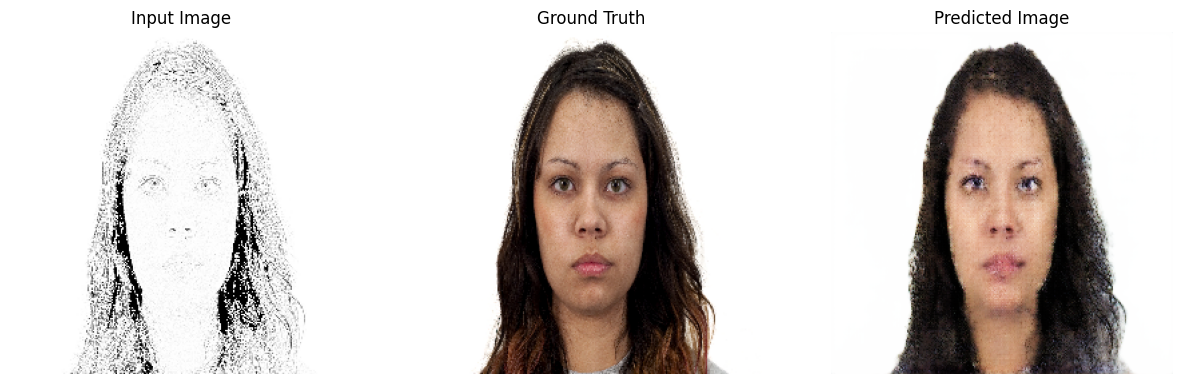

In [32]:
generate_images(generator, test_ds[0][30].reshape([1,256,256,3]), test_ds[1][30].reshape([1,256,256,3]))